# Hubs susceptibility

### Libraries

In [38]:
import os
import numpy as np
import nibabel as nb
import pandas as pd
import glob
import matplotlib.pyplot as plt
from enigmatoolbox.plotting import plot_cortical
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.utils.parcellation import surface_to_parcel
from enigmatoolbox.datasets import load_sc, load_fc
from nilearn import plotting
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainstat.datasets import fetch_mask
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
from brainspace.datasets import load_mask
from brainspace.utils.parcellation import map_to_labels
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
import networkx as nx
from igraph import Graph

### Load surfaces and masks

In [2]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Path to MICAPIPE surf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load fsLR 32k
f32k_lh = read_surface(micapipe + '/surfaces/fsLR-32k.L.surf.gii', itype='gii')
f32k_rh = read_surface(micapipe + '/surfaces/fsLR-32k.R.surf.gii', itype='gii')

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

f5k_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.surf.gii', itype='gii')
f5k_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.surf.gii', itype='gii')

# Load fsLR masks
mask_32k = load_mask(join=True)

# Load fsaverage5
fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.pial', itype='fs')
fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.pial', itype='fs')
fs5_mask = fetch_mask("fsaverage5")

# Load fsaverage5 inflated surfaces and mask
#fs5_lh = read_surface(micapipe+'/surfaces/fsaverage5/surf/lh.inflated', itype='fs')
#fs5_rh = read_surface(micapipe+'/surfaces/fsaverage5/surf/rh.inflated', itype='fs')
#fs5_mask = fetch_mask("fsaverage5")

## Load cortico-cortical structural connectivity data

In [3]:
# Load CSV file containing subject and session information
csv_dir = '/data/mica1/03_projects/youngeun/lists'
csv_file = f"10PNC_T1map.csv"
subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

# Extract subject and session information from each row
files = []
for index, row in subject_session_info.iterrows():
    info = row['info'].split(',')
    subject = index[4:]  # Extract subject ID
    session = info[0][4:].strip()  # Extract session ID
    files_sc = f"sub-{subject}/ses-02/dwi/connectomes/*_space-dwi_atlas-schaefer-400_desc-iFOD2-40M-SIFT2_full-connectome.shape.gii"
    files.extend(glob.glob(files_sc))

# Load intensity profiles from each file
profiles = []
for file_path in files:
    profile_data = nb.load(file_path).darrays[0].data
    profiles.append(profile_data)
profiles = np.array(profiles)
sc = np.mean(profiles, axis=0)
sc_sym = np.triu(sc,1)+sc.T

## Load cortico-cortical functional connectivity data

In [4]:
# Load CSV file containing subject and session information
csv_dir = '/data/mica1/03_projects/youngeun/lists'
csv_file = f"10PNC_T1map.csv"
subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

# Extract subject and session information from each row
files = []
for index, row in subject_session_info.iterrows():
    info = row['info'].split(',')
    subject = index[4:]  # Extract subject ID
    session = info[0][4:].strip()  # Extract session ID
    files_fc = f"sub-{subject}/ses-03/func/desc-me_task-rest_bold/surf/*_surf-fsLR-32k_atlas-schaefer-400_desc-FC.shape.gii"
    files.extend(glob.glob(files_fc))

# Load intensity profiles from each file
profiles = []
for file_path in files:
    profile_data = nb.load(file_path).darrays[0].data
    profiles.append(profile_data)
profiles = np.array(profiles)
fc = np.mean(profiles, axis=0)
fc_sym = np.triu(fc,1)+fc.T

## Load cortical connectivity matrices

/tmp/ipykernel_855362/2848593962.py:2: RuntimeWarning: divide by zero encountered in log
  sc_plot = plotting.plot_matrix(np.log(sc_sym), figure=(10, 10), labels=None, cmap='Purples')


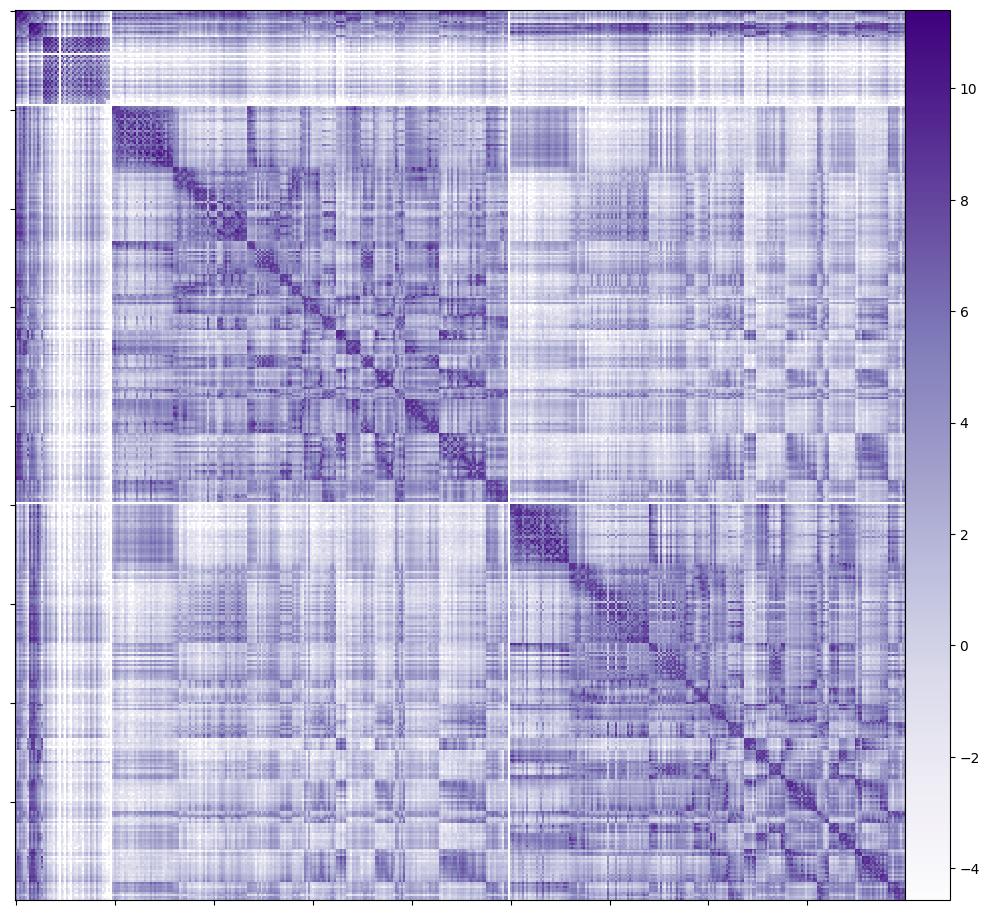

In [5]:
# Plot cortico-cortical connectivity matrices
sc_plot = plotting.plot_matrix(np.log(sc_sym), figure=(10, 10), labels=None, cmap='Purples')

(449, 449)


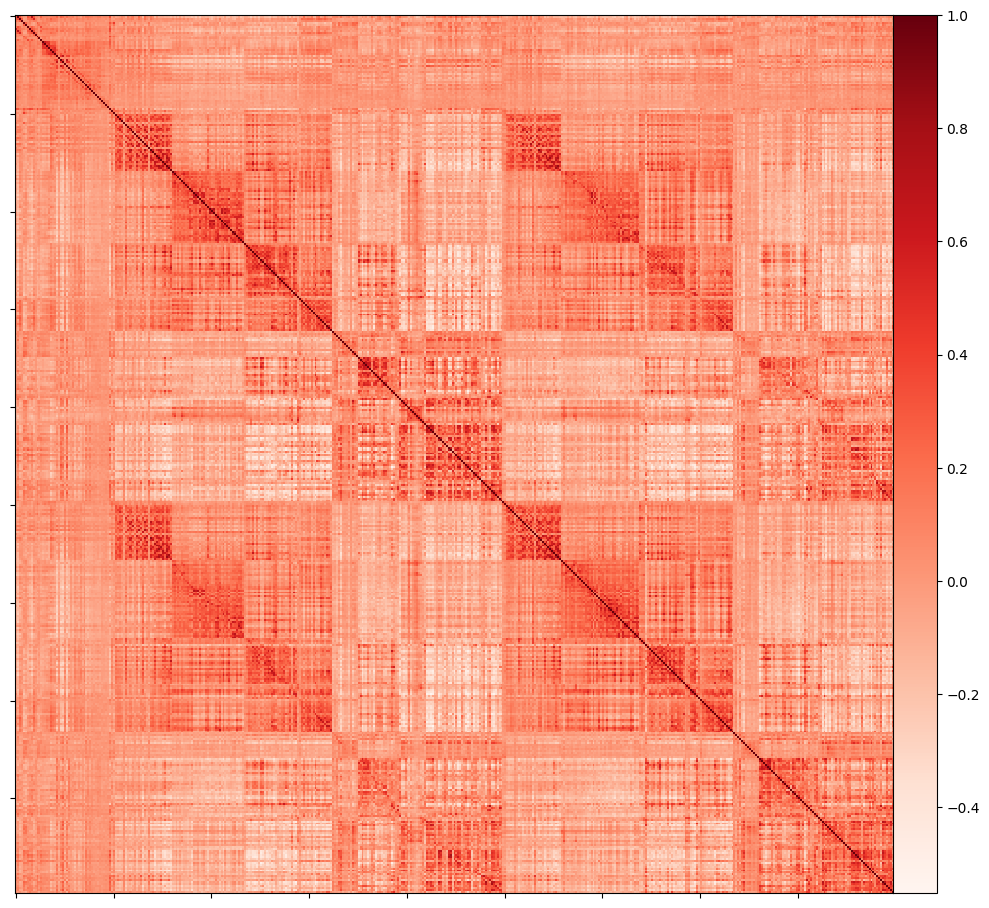

In [6]:
# Plot cortico-cortical connectivity matrices
fc_plot = plotting.plot_matrix(fc_sym, figure=(10, 10), labels=None, cmap='Reds')
print(fc_sym.shape)

## Degre Centrality (cortical hubs)

### Structural Connectivity

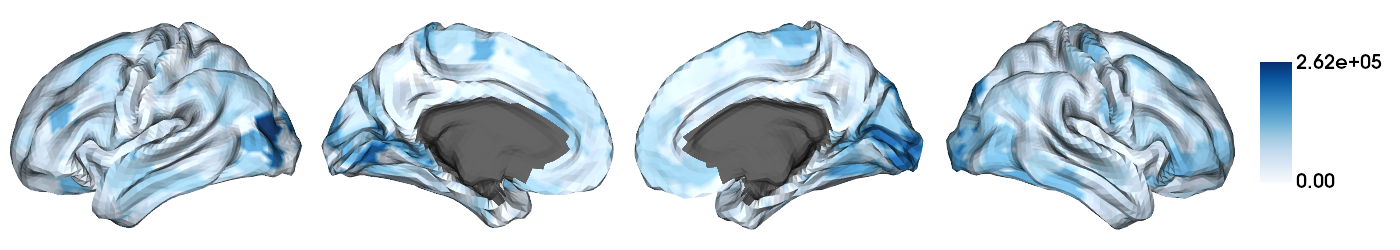

In [14]:
# Copy the matrix
#sc_pos = sc_sym
# Replace all negative value with 0
#sc_pos[sc_sym < 0] = 0

# Consider the absolute value
sc_abs = np.abs(sc_sym)

# Compute weighted degree centrality measures from the connectivity data
#sc_ctx = np.sum(sc_abs[52:,52:], axis=0)
sc_ctx = np.sum(sc_abs[50:,50:], axis=0)

# Map parcellated data to the surface
sc_ctx_dc = parcel_to_surface(sc_ctx, 'schaefer-400_fsLR5k')

sc_ctx_dc[mask_5k == False] = np.nan

plot_hemispheres(f5k_lh, f5k_rh, sc_ctx_dc, cmap='Blues', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

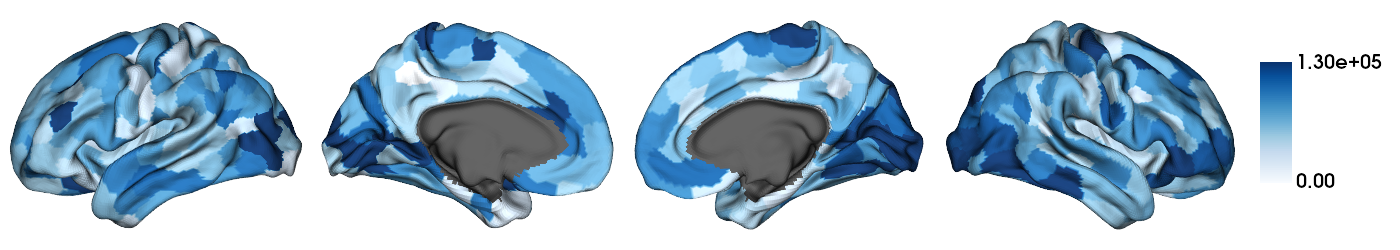

In [214]:
# Copy the matrix
#sc_pos = sc_sym
# Replace all negative value with 0
#sc_pos[sc_sym < 0] = 0

# Consider the absolute value
sc_abs = np.abs(sc_sym)

# Compute weighted degree centrality measures from the connectivity data
#sc_ctx = np.sum(sc_abs[52:,52:], axis=0)
sc_ctx = np.sum(sc_abs[50:,50:], axis=0)

# Map parcellated data to the surface
sc_ctx_dc = parcel_to_surface(sc_ctx, 'schaefer_400_conte69')

sc_ctx_dc[mask_32k == False] = np.nan

plot_hemispheres(f32k_lh, f32k_rh, sc_ctx_dc, cmap='Blues', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=(0, 130000),
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

/tmp/ipykernel_855362/298948748.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_855362/298948748.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


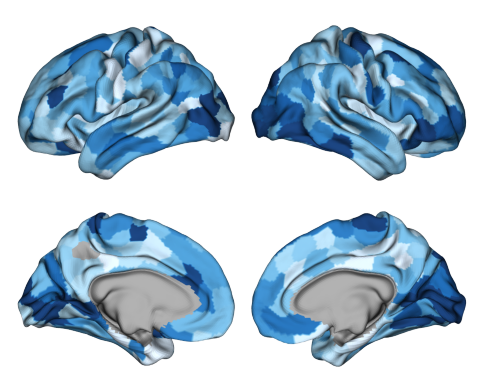

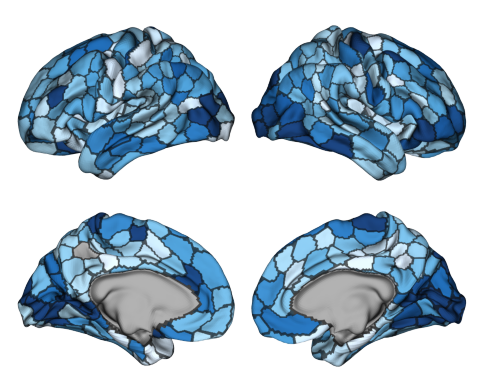

In [217]:
surfaces = fetch_fslr()
p = Plot(f32k_lh, f32k_rh)

# add schaefer parcellation (no color bar needed)
left = sc_ctx_dc[:len(sc_ctx_dc)//2]
right = sc_ctx_dc[len(sc_ctx_dc)//2:]
p.add_layer({'left': left, 'right': right}, cbar=False, cmap='Blues', color_range=(0, 130000),)

fig = p.build()
fig.show()

p.add_layer({'left': left, 'right': right}, cmap='gray', 
            as_outline=True, cbar=False, alpha=0.7)
fig = p.build()
fig.show()

### Functional Connectivity

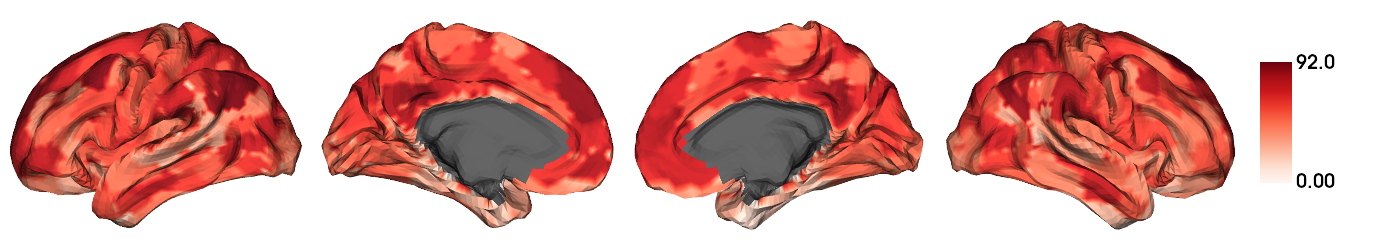

In [15]:
# Copy the matrix
#fc_pos = fc_sym
# Replace all negative value with 0
#fc_pos[fc_sym<0] = 0

# Consider the absolute value
fc_abs = np.abs(fc_sym)

# Compute weighted degree centrality measures from the connectivity data
#fc_ctx = np.sum(fc_abs[51:,51:], axis=0)
fc_ctx = np.sum(fc_abs[49:,49:], axis=0)

# Map parcellated data to the surface
fc_ctx_dc = parcel_to_surface(fc_ctx, 'schaefer-400_fsLR5k')

fc_ctx_dc[mask_5k == False] = np.nan

plot_hemispheres(f5k_lh, f5k_rh, fc_ctx_dc, cmap='Reds', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

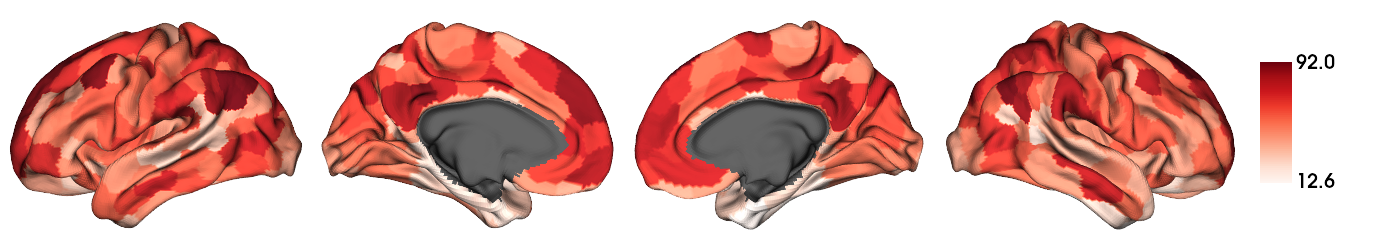

In [10]:
# Copy the matrix
#fc_pos = fc_sym
# Replace all negative value with 0
#fc_pos[fc_sym<0] = 0

# Consider the absolute value
fc_abs = np.abs(fc_sym)

# Compute weighted degree centrality measures from the connectivity data
#fc_ctx = np.sum(fc_abs[51:,51:], axis=0)
fc_ctx = np.sum(fc_abs[49:,49:], axis=0)

# Map parcellated data to the surface
fc_ctx_dc = parcel_to_surface(fc_ctx, 'schaefer_400_conte69')

fc_ctx_dc[mask_32k == False] = np.nan

plot_hemispheres(f32k_lh, f32k_rh, fc_ctx_dc, cmap='Reds', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True,
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

/tmp/ipykernel_3791933/3995670243.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_3791933/3995670243.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


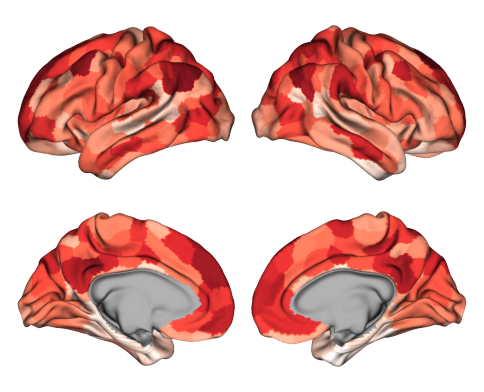

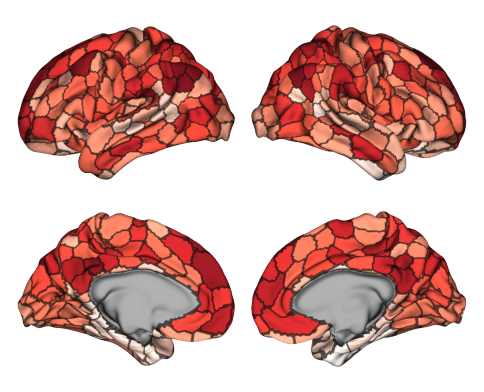

In [190]:
surfaces = fetch_fslr()
p = Plot(f32k_lh, f32k_rh)

# add schaefer parcellation (no color bar needed)
left = fc_ctx_dc[:len(fc_ctx_dc)//2]
right = fc_ctx_dc[len(fc_ctx_dc)//2:]
p.add_layer({'left': left, 'right': right}, cbar=False, cmap='Reds')

fig = p.build()
fig.show()

p.add_layer({'left': left, 'right': right}, cmap='gray',
            as_outline=True, cbar=False, alpha=0.7)
fig = p.build()
fig.show()

### Load SWM & Cortical Gradients

In [11]:
#SWM_mMPC = np.load('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_5k_SWM_G1.npy')
SWM_mMPC = np.load('/host/percy/local_raid/youngeun/myjupyter/array/mMPC_SWM_G1_T1map_MTSAT.npy')
SWM_T1map = np.load('/host/percy/local_raid/youngeun/myjupyter/array/T1map_SWM_G1.npy')
SWM_MTSAT = np.load('/host/percy/local_raid/youngeun/myjupyter/array/MTSAT_SWM_G1_new.npy')
SWM_FA = np.load('/host/percy/local_raid/youngeun/myjupyter/array/FA_SWM_G1.npy')
SWM_ODI = np.load('/host/percy/local_raid/youngeun/myjupyter/array/ODI_SWM_G1.npy')

GM_T1map = np.load('/host/percy/local_raid/youngeun/myjupyter/array/T1map_GM_G1.npy')

In [196]:
# Parcellate vertexwise data
SWM_mMPC_parc = surface_to_parcel(SWM_mMPC, 'schaefer-400_fsLR5k')
print(SWM_mMPC_parc.shape)
SWM_T1map_parc = surface_to_parcel(SWM_T1map, 'schaefer-400_fsLR5k')
print(SWM_T1map_parc.shape)
SWM_MTSAT_parc = surface_to_parcel(SWM_MTSAT, 'schaefer-400_fsLR5k')
print(SWM_MTSAT_parc.shape)
SWM_FA_parc = surface_to_parcel(SWM_FA, 'schaefer-400_fsLR5k')
print(SWM_FA_parc.shape)
SWM_ODI_parc = surface_to_parcel(SWM_ODI, 'schaefer-400_fsLR5k')
print(SWM_ODI_parc.shape)
GM_T1map_parc = surface_to_parcel(GM_T1map, 'schaefer-400_fsLR5k')
print(GM_T1map_parc.shape)

(401,)
(401,)
(401,)
(401,)
(401,)
(401,)


In [197]:
fc_aparc = surface_to_parcel(fc_ctx_dc, 'schaefer-400_fsLR5k')
print(fc_aparc.shape)
sc_aparc = surface_to_parcel(sc_ctx_dc, 'schaefer-400_fsLR5k')
print(sc_aparc.shape)

(401,)
(401,)


### Correlation between Functional Hubs & SWM mMPC

<Figure size 600x600 with 0 Axes>

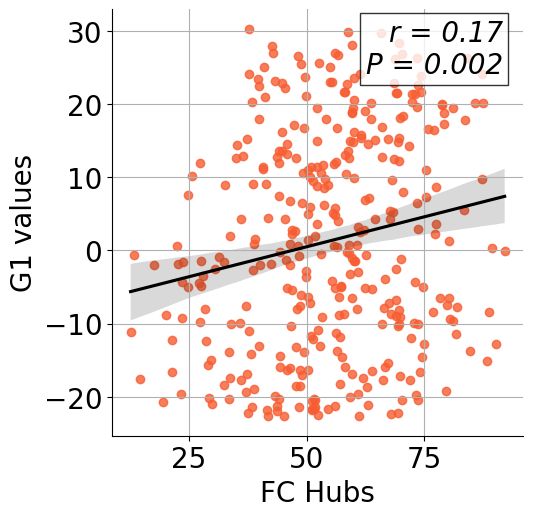

In [17]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(SWM_mMPC_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_SWM_mMPC_parc = SWM_mMPC_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_SWM_mMPC_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'SWM_mMPC_parc': valid_SWM_mMPC_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='fc_aparc', y='SWM_mMPC_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('FC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Functional Hubs & GM_T1map

<Figure size 800x600 with 0 Axes>

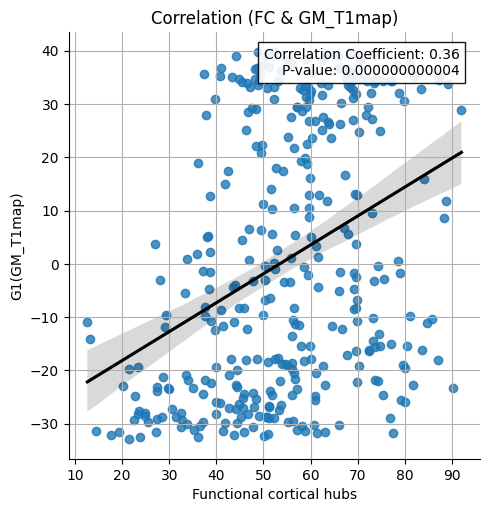

In [14]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(GM_T1map_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_GM_T1map_parc = GM_T1map_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_GM_T1map_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'GM_T1map_parc': valid_GM_T1map_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(8, 6))
sns.lmplot(x='fc_aparc', y='GM_T1map_parc', data=df, line_kws={'color': 'black'})

plt.title('Correlation (FC & GM_T1map)')
plt.xlabel('Functional cortical hubs')
plt.ylabel('G1(GM_T1map)')
plt.text(0.95, 0.9, f'Correlation Coefficient: {r:.2f}\nP-value: {p:.12f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.9), fontsize=10)

plt.grid(True)
plt.show()

### Correlation between Functional Hubs & SWM T1map

<Figure size 600x600 with 0 Axes>

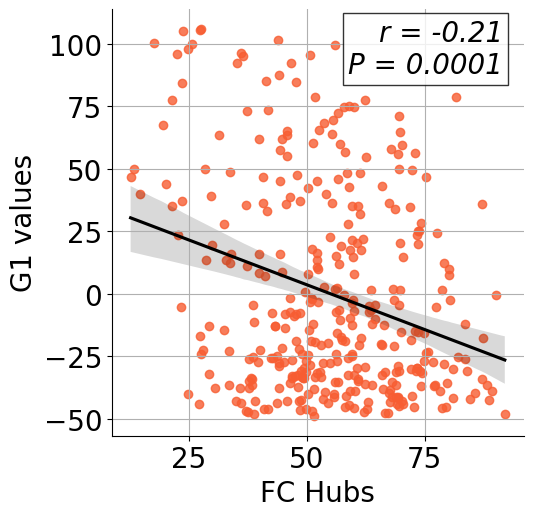

In [19]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(SWM_T1map_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_SWM_T1map_parc = SWM_T1map_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_SWM_T1map_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'SWM_T1map_parc': valid_SWM_T1map_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='fc_aparc', y='SWM_T1map_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('FC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.4f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Functional Hubs & SWM MTSAT (New)

<Figure size 600x600 with 0 Axes>

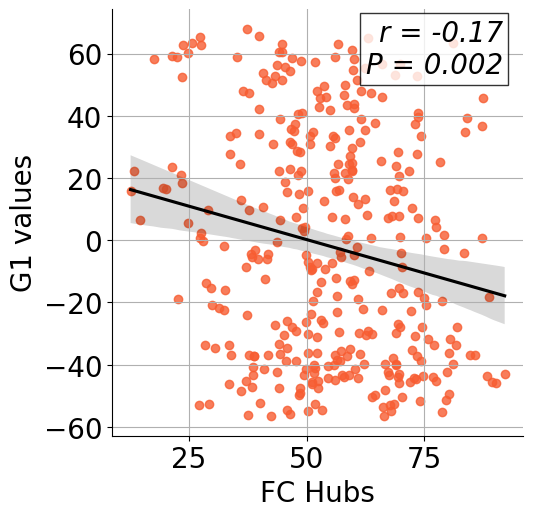

In [20]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(SWM_MTSAT_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_SWM_MTSAT_parc = SWM_MTSAT_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_SWM_MTSAT_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'SWM_MTSAT_parc': valid_SWM_MTSAT_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='fc_aparc', y='SWM_MTSAT_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('FC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Functional Hubs & SWM FA

<Figure size 600x600 with 0 Axes>

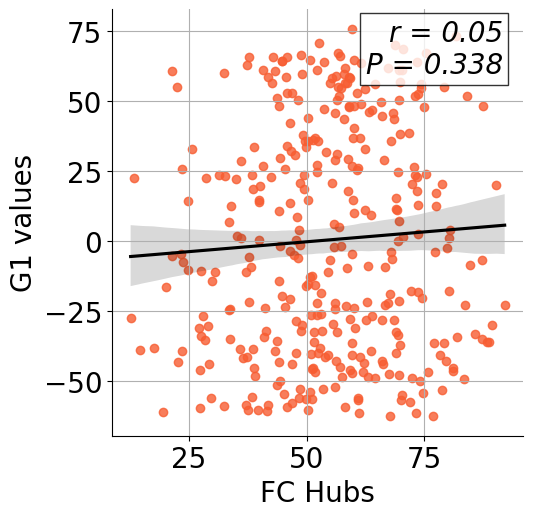

In [238]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(SWM_FA_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_SWM_FA_parc = SWM_FA_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_SWM_FA_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'SWM_FA_parc': valid_SWM_FA_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='fc_aparc', y='SWM_FA_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('FC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Functional Hubs & SWM ODI

<Figure size 600x600 with 0 Axes>

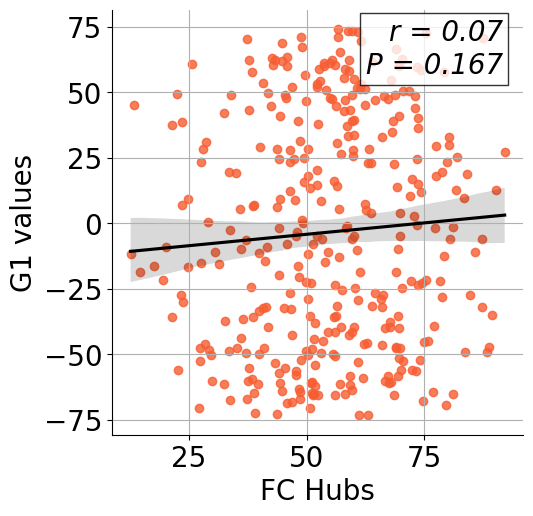

In [239]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(SWM_ODI_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_SWM_ODI_parc = SWM_ODI_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_SWM_ODI_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'SWM_ODI_parc': valid_SWM_ODI_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='fc_aparc', y='SWM_ODI_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('FC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Structural Hubs & SWM mMPC

<Figure size 600x600 with 0 Axes>

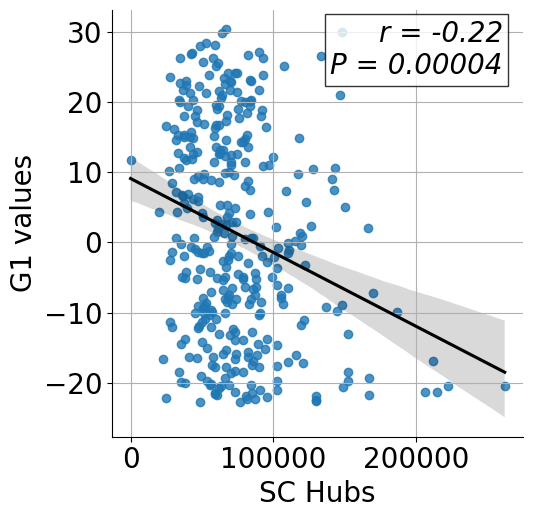

In [200]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(SWM_mMPC_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_SWM_mMPC_parc = SWM_mMPC_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_SWM_mMPC_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'SWM_mMPC_parc': valid_SWM_mMPC_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='sc_aparc', y='SWM_mMPC_parc', data=df, line_kws={'color': 'black'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('SC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.5f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Structural Hubs & GM T1map

<Figure size 800x600 with 0 Axes>

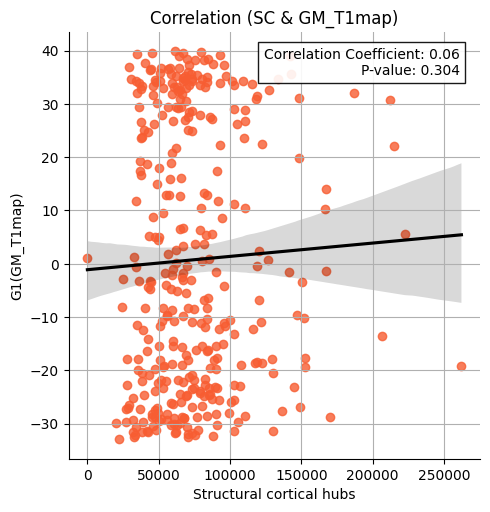

In [128]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(GM_T1map_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_GM_T1map_parc = GM_T1map_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_GM_T1map_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'GM_T1map_parc': valid_GM_T1map_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(8, 6))
sns.lmplot(x='sc_aparc', y='GM_T1map_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

plt.title('Correlation (SC & GM_T1map)')
plt.xlabel('Structural cortical hubs')
plt.ylabel('G1(GM_T1map)')
plt.text(0.95, 0.9, f'Correlation Coefficient: {r:.2f}\nP-value: {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.9), fontsize=10)

plt.grid(True)
plt.show()

### Correlation between Structural Hubs & SWM T1map

<Figure size 600x600 with 0 Axes>

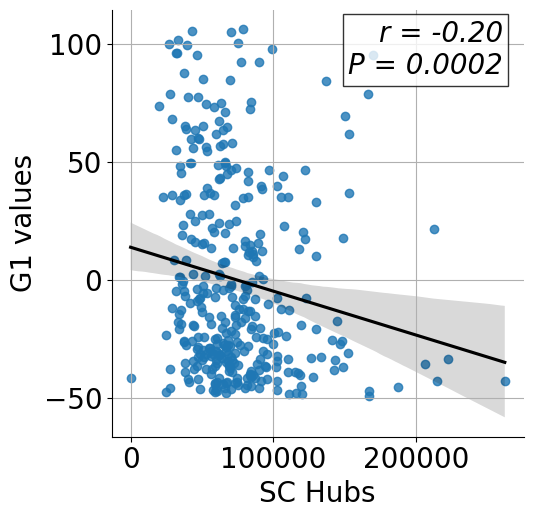

In [201]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(SWM_T1map_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_SWM_T1map_parc = SWM_T1map_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_SWM_T1map_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'SWM_T1map_parc': valid_SWM_T1map_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='sc_aparc', y='SWM_T1map_parc', data=df, line_kws={'color': 'black'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('SC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.4f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Structural Hubs & SWM MTSAT (New)

<Figure size 600x600 with 0 Axes>

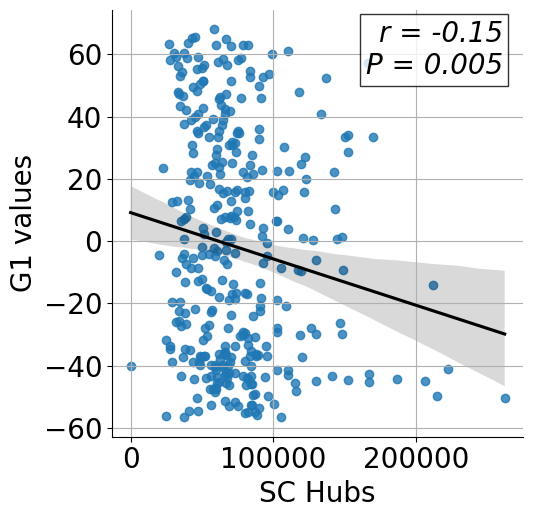

In [202]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(SWM_MTSAT_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_SWM_MTSAT_parc = SWM_MTSAT_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_SWM_MTSAT_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'SWM_MTSAT_parc': valid_SWM_MTSAT_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='sc_aparc', y='SWM_MTSAT_parc', data=df, line_kws={'color': 'black'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('SC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Structural Hubs & SWM FA

<Figure size 600x600 with 0 Axes>

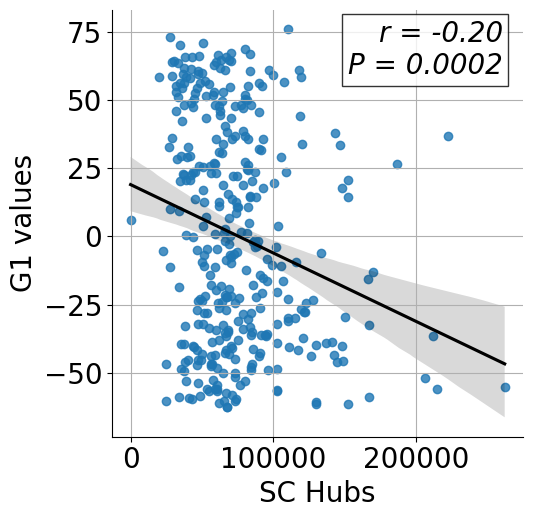

In [242]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(SWM_FA_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_SWM_FA_parc = SWM_FA_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_SWM_FA_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'SWM_FA_parc': valid_SWM_FA_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='sc_aparc', y='SWM_FA_parc', data=df, line_kws={'color': 'black'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('SC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.4f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Structural Hubs & SWM ODI

<Figure size 600x600 with 0 Axes>

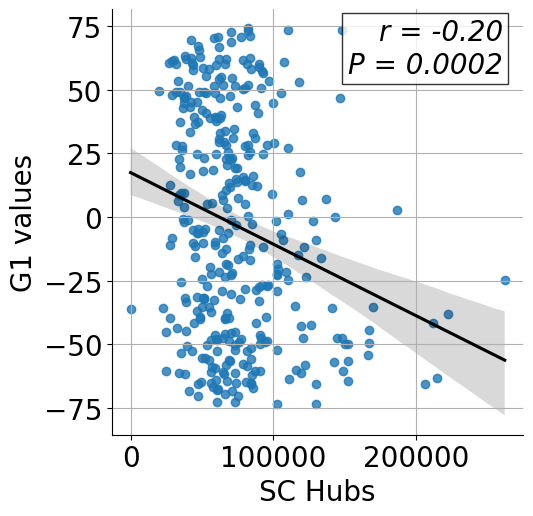

In [243]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(SWM_ODI_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_SWM_ODI_parc = SWM_ODI_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_SWM_ODI_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'SWM_ODI_parc': valid_SWM_ODI_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='sc_aparc', y='SWM_ODI_parc', data=df, line_kws={'color': 'black'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('SC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.4f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

In [48]:
# Create a graph object from adjancency matrix
from igraph import Graph

In [158]:
# Remove the loops from the diagonal (1)
np.fill_diagonal(fc_abs[49:,49:], 0)

# Create a graph object
A = fc_abs[49:,49:]
G = Graph.Weighted_Adjacency((A>0).tolist(), mode='undirected', attr='weight')
G.es['weight'] = A[A.nonzero()]

#G.get_adjacency(attribute='weight')

## FC betweenness

In [167]:
Gbtw = np.array(G.betweenness(weights='weight'))

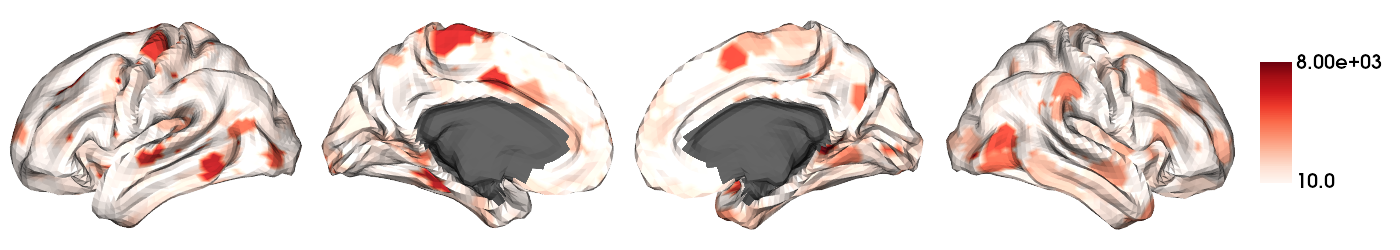

In [168]:
# Map parcellated data to the surface
Gbtw_dc = parcel_to_surface(Gbtw, 'schaefer-400_fsLR5k')

Gbtw_dc[mask_5k == False] = np.nan

plot_hemispheres(f5k_lh, f5k_rh, Gbtw_dc, cmap='Reds', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=(10, 8000),
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

## FC strength

In [173]:
Gstg = np.array(G.strength(weights='weight'))

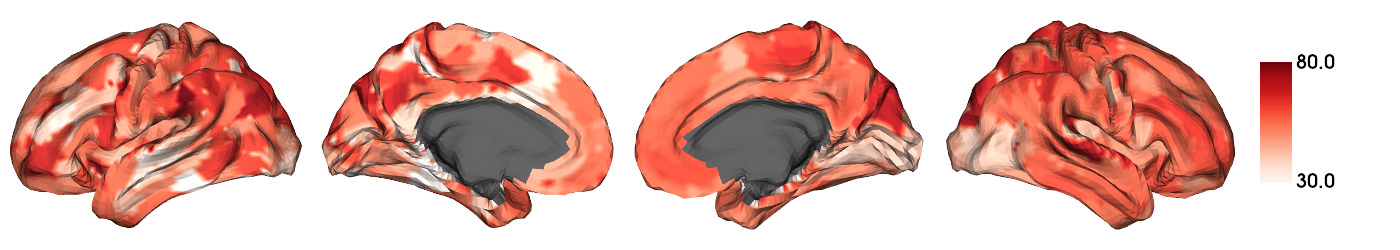

In [174]:
# Map parcellated data to the surface
Gstg_dc = parcel_to_surface(Gstg, 'schaefer-400_fsLR5k')

Gstg_dc[mask_5k == False] = np.nan

plot_hemispheres(f5k_lh, f5k_rh, Gstg_dc, cmap='Reds', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=(30, 80),
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

## FC hub score

In [159]:
Ghub = np.array(G.hub_score(weights='weight'))

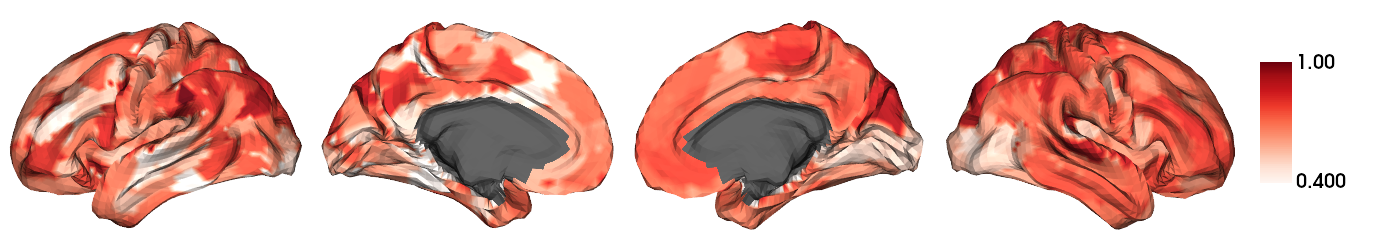

In [160]:
# Map parcellated data to the surface
Ghub_dc = parcel_to_surface(Ghub, 'schaefer-400_fsLR5k')

Ghub_dc[mask_5k == False] = np.nan

plot_hemispheres(f5k_lh, f5k_rh, Ghub_dc, cmap='Reds', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=(0.4, 1),
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

In [175]:
fc_aparc = surface_to_parcel(Gstg_dc, 'schaefer-400_fsLR5k')
print(fc_aparc.shape)

(401,)


### Correlation between Functional Hubs & SWM mMPC

<Figure size 600x600 with 0 Axes>

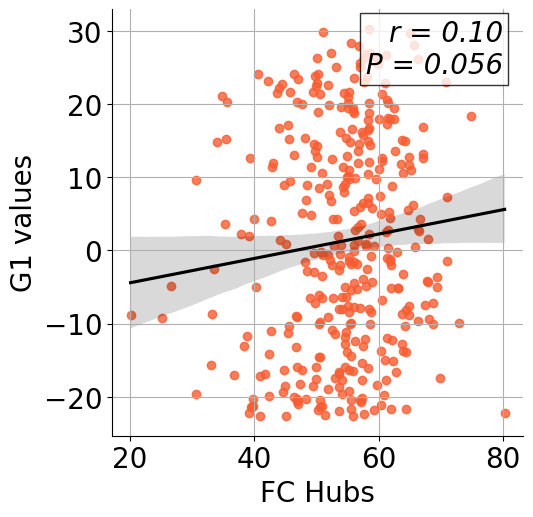

In [176]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(SWM_mMPC_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_SWM_mMPC_parc = SWM_mMPC_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_SWM_mMPC_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'SWM_mMPC_parc': valid_SWM_mMPC_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='fc_aparc', y='SWM_mMPC_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('FC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Functional Hubs & SWM T1map

<Figure size 600x600 with 0 Axes>

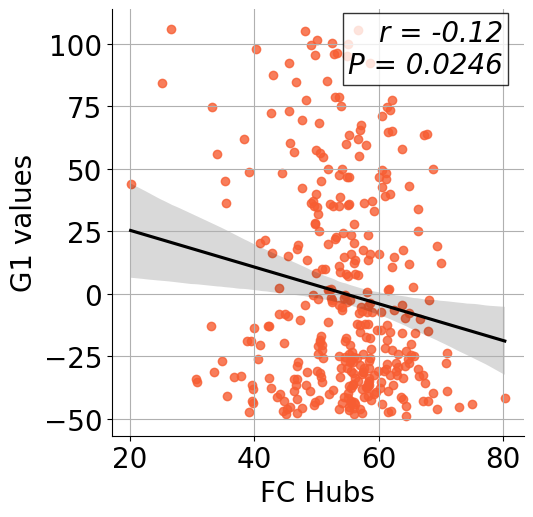

In [177]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(SWM_T1map_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_SWM_T1map_parc = SWM_T1map_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_SWM_T1map_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'SWM_T1map_parc': valid_SWM_T1map_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='fc_aparc', y='SWM_T1map_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('FC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.4f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Functional Hubs & SWM MTSAT

<Figure size 600x600 with 0 Axes>

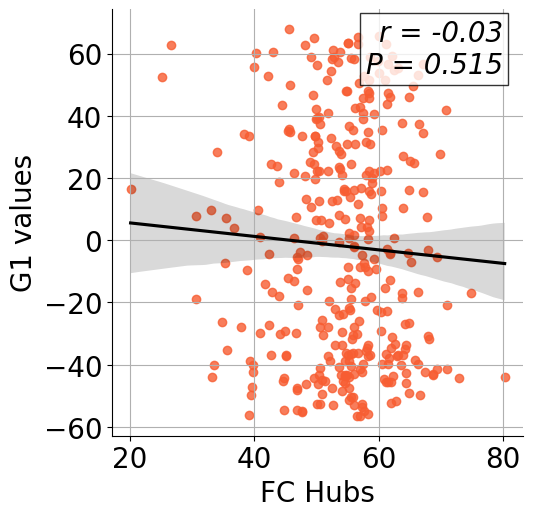

In [178]:
valid_indices = ~np.isnan(fc_aparc) & ~np.isnan(SWM_MTSAT_parc)
valid_fc_aparc = fc_aparc[valid_indices]
valid_SWM_MTSAT_parc = SWM_MTSAT_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_fc_aparc, valid_SWM_MTSAT_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'fc_aparc': valid_fc_aparc, 'SWM_MTSAT_parc': valid_SWM_MTSAT_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='fc_aparc', y='SWM_MTSAT_parc', data=df, line_kws={'color': 'black'}, scatter_kws={'color': '#F75D32'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('FC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

In [135]:
# Remove the loops from the diagonal (1)
np.fill_diagonal(sc_abs[50:,50:], 0)

# Create a graph object
A = sc_abs[49:,49:]
G = Graph.Weighted_Adjacency((A>0).tolist(), mode='undirected', attr='weight')
G.es['weight'] = A[A.nonzero()]

#G.get_adjacency(attribute='weight')

## SC betweeness

In [136]:
Sbtw = np.array(G.betweenness(weights='weight'))

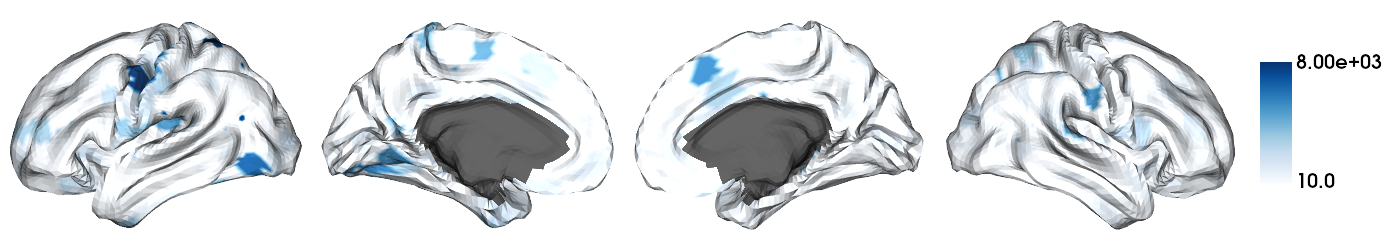

In [137]:
# Map parcellated data to the surface
Sbtw_dc = parcel_to_surface(Sbtw, 'schaefer-400_fsLR5k')

Sbtw_dc[mask_5k == False] = np.nan

plot_hemispheres(f5k_lh, f5k_rh, Sbtw_dc, cmap='Blues', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=(10, 8000),
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

## SC stregth

In [138]:
Sstg = np.array(G.strength(weights='weight'))

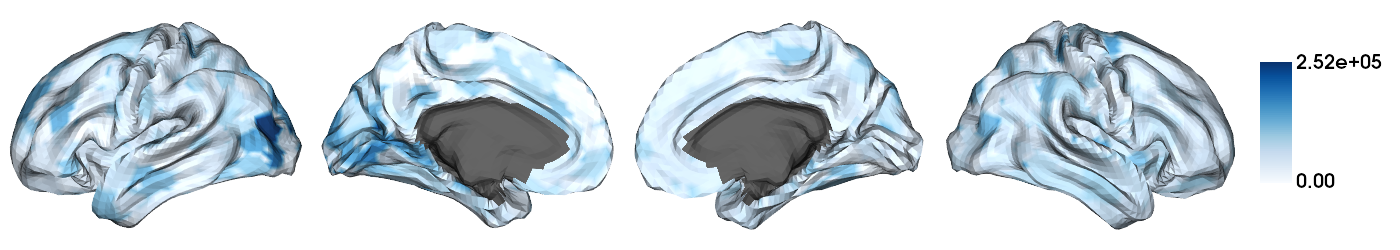

In [148]:
# Map parcellated data to the surface
Sstg_dc = parcel_to_surface(Sstg, 'schaefer-400_fsLR5k')

Sstg_dc[mask_5k == False] = np.nan

plot_hemispheres(f5k_lh, f5k_rh, Sstg_dc, cmap='Blues', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, 
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

## SC hub score

In [141]:
Shub = np.array(G.hub_score(weights='weight'))

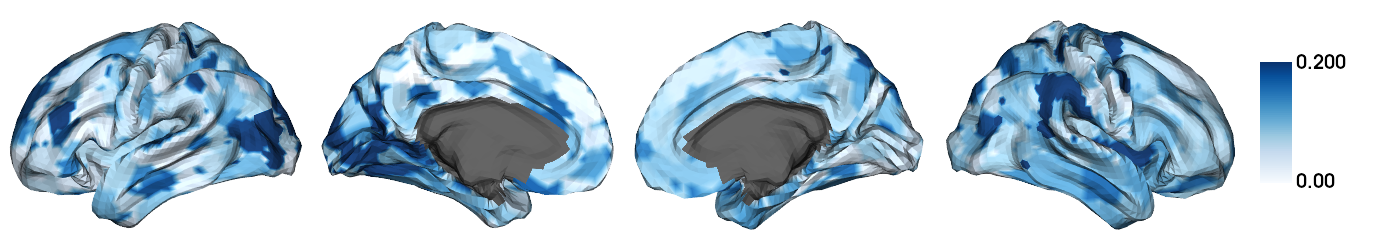

In [157]:
# Map parcellated data to the surface
Shub_dc = parcel_to_surface(Shub, 'schaefer-400_fsLR5k')

Shub_dc[mask_5k == False] = np.nan

plot_hemispheres(f5k_lh, f5k_rh, Shub_dc, cmap='Blues', nan_color=(0.3, 0.3, 0.3, 1),
                      zoom=1.5, size=(1400, 250), embed_nb=True, color_range=(0, 0.2),
                      color_bar='right', cb__labelTextProperty={"fontSize": 20})

In [192]:
sc_aparc = surface_to_parcel(Shub_dc, 'schaefer-400_fsLR5k')
print(fc_aparc.shape)

(401,)


### Correlation between Structural Hubs & SWM mMPC

<Figure size 600x600 with 0 Axes>

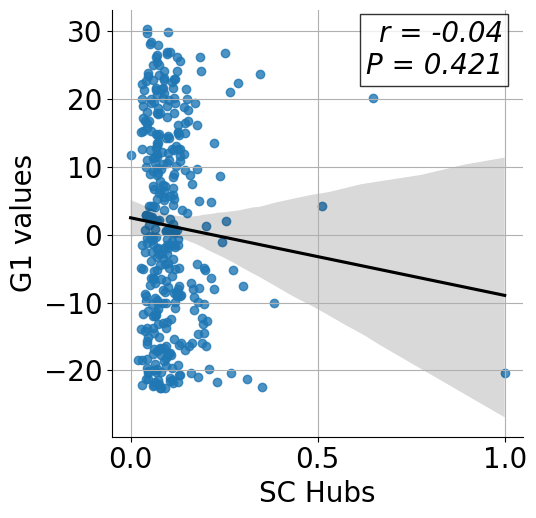

In [193]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(SWM_mMPC_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_SWM_mMPC_parc = SWM_mMPC_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_SWM_mMPC_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'SWM_mMPC_parc': valid_SWM_mMPC_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='sc_aparc', y='SWM_mMPC_parc', data=df, line_kws={'color': 'black'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('SC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Structural Hubs & SWM T1map

<Figure size 600x600 with 0 Axes>

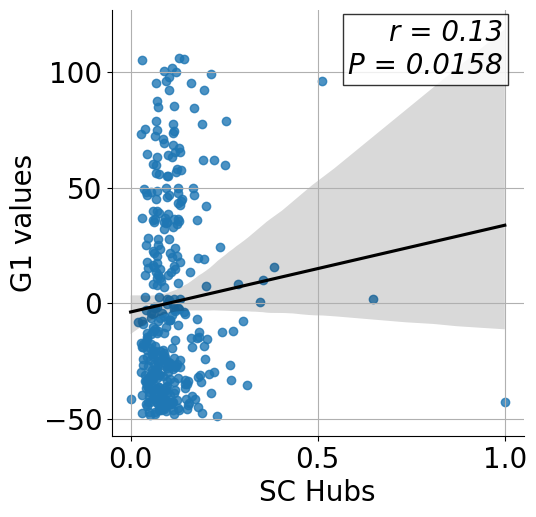

In [194]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(SWM_T1map_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_SWM_T1map_parc = SWM_T1map_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_SWM_T1map_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'SWM_T1map_parc': valid_SWM_T1map_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='sc_aparc', y='SWM_T1map_parc', data=df, line_kws={'color': 'black'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('SC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.4f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()

### Correlation between Structural Hubs & SWM MTSAT

<Figure size 600x600 with 0 Axes>

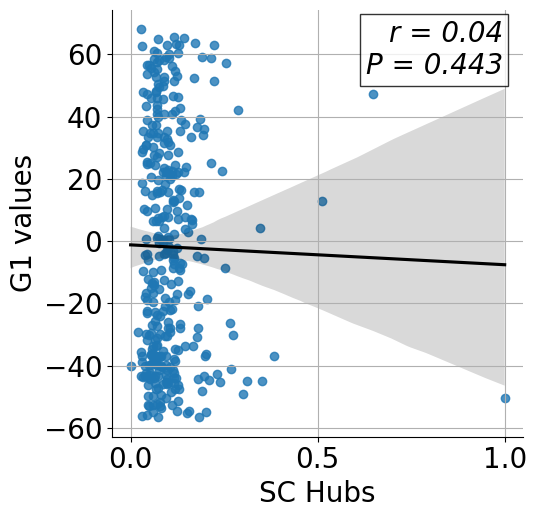

In [195]:
valid_indices = ~np.isnan(sc_aparc) & ~np.isnan(SWM_MTSAT_parc)
valid_sc_aparc = sc_aparc[valid_indices]
valid_SWM_MTSAT_parc = SWM_MTSAT_parc[valid_indices]

# Calculate Spearman correlation coefficient and p-value
r, p = sp.stats.spearmanr(valid_sc_aparc, valid_SWM_MTSAT_parc)

# Convert NumPy arrays to a DataFrame
df = pd.DataFrame({'sc_aparc': valid_sc_aparc, 'SWM_MTSAT_parc': valid_SWM_MTSAT_parc})

# Plot scatter plot and add a linear regression line using seaborn
plt.figure(figsize=(6, 6))
sns.lmplot(x='sc_aparc', y='SWM_MTSAT_parc', data=df, line_kws={'color': 'black'})

#plt.title('Correlation (FC & SWM_T1map)')
plt.xlabel('SC Hubs', fontsize=20)
plt.ylabel('G1 values', fontsize=20)
plt.text(0.95, 0.85, f'r = {r:.2f}\nP = {p:.3f}', transform=plt.gca().transAxes, ha='right',
        bbox=dict(facecolor='white', alpha=0.8), fontsize=20, fontstyle='italic')
plt.tick_params(axis='y', labelsize=20)  # Adjust the label size as needed
plt.tick_params(axis='x', labelsize=20)  # Adjust the label size as needed

plt.grid(True)
plt.show()